In [1]:
import torch
import torch.nn as nn

In [2]:
# Set random seed for reproducibility
from cycleGAN.utils import set_seed, get_GAN_dataloader
set_seed()

workers = 8
batch_size = 3
image_size = 256

# Create dataloaders
X_dataloader, Y_dataloader = get_GAN_dataloader("test/blonde_", "test/brunette_", batch_size, image_size, workers)

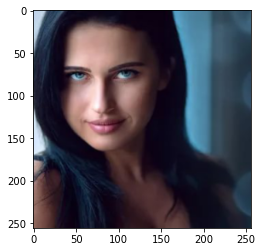

In [3]:
# Plot some training images
from cycleGAN.utils import plot

sample = next(iter(Y_dataloader))
plot(sample)

In [4]:
# Create the Generator, Discriminator with initialized parameters and their optimizers
from cycleGAN.train import get_GAN

lr = 0.001
beta = 0.5
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

criterion = nn.MSELoss()

(G_X, D_X), (D_X_opt, G_X_opt) = get_GAN(lr, beta, device)
(G_Y, D_Y), (D_Y_opt, G_Y_opt) = get_GAN(lr, beta, device)

In [5]:
from cycleGAN.utils import load_data

load_data(G_X, D_X, G_Y, D_Y, '')

In [ ]:
# Training Loop

from cycleGAN.train import train_GAN, train_cycle
from cycleGAN.utils import dual_plot, update_weights, update_lr

X_GAN_loss = []
Y_GAN_loss = []
iters = 10

print("Starting Training Loop...")
for epoch in range(100):
    for i, (X, Y) in enumerate(zip(X_dataloader, Y_dataloader), 0):
        for _ in range(10):
            try:
                G_X_generated, X_cumulative_error = train_GAN(D=D_X, 
                                         G=G_X, 
                                         D_opt=D_X_opt,
                                         G_opt=G_X_opt,
                                         starting_images=X[0].to(device),
                                         target_images=Y[0].to(device), 
                                         batch_size=batch_size,
                                         criterion=criterion,
                                         device=device)     
                G_Y_generated, Y_cumulative_error = train_GAN(D=D_Y, 
                                         G=G_Y, 
                                         D_opt=D_Y_opt,
                                         G_opt=G_Y_opt,
                                         starting_images=Y[0].to(device),
                                         target_images=X[0].to(device), 
                                         batch_size=batch_size, 
                                         criterion=criterion,
                                         device=device)
                train_cycle(G_X, 
                        G_Y, 
                        G_X_opt, 
                        G_Y_opt, 
                        X[0].to(device), 
                        Y[0].to(device))
            except:
                pass

            X_GAN_loss.append(X_cumulative_error)
            Y_GAN_loss.append(Y_cumulative_error)

            if (iters % 10 == 0) and (iters % 20 != 0):
                update_weights(D_X, G_X, D_Y, G_Y, X_GAN_loss, Y_GAN_loss)
                print(iters, X_GAN_loss[-1][1], Y_GAN_loss[-1][1], "G_X_generated images:")
                dual_plot(X, G_X_generated)

            if iters % 20 == 0:
                print(iters, X_GAN_loss[-1][1], Y_GAN_loss[-1][1], "G_Y_generated images:")
                dual_plot(Y, G_Y_generated)

            iters += 1
    update_lr(D_X, G_X, D_Y, G_Y, D_X_opt, G_X_opt, D_Y_opt, G_Y_opt, lr, beta, epoch)

Starting Training Loop...


In [ ]:
G_X.eval()
real_batch = next(iter(X_dataloader))
output = G_X(real_batch[0].to(device))
sample = output.to('cpu').detach()[0, :, :, :].permute(1,2,0).numpy()

real_batch = real_batch[0][0, :, :, :].permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(real_batch, cmap='Greys')
plt.subplot(1,2,2)
plt.imshow(sample, cmap='Greys')